In [2]:
%reload_ext autoreload
%autoreload 2
import opt
from spice_net import *
import numpy as np
import matplotlib.pyplot as plt

#### Generate the dataset

In [3]:
# Generate N random points
N = 1000
split = 0.8
pts = np.random.rand(N, 2)

# Split into training and testing datasets
np.random.shuffle(pts)
train, test = {}, {}
train['x'], test['x'] = pts[:int(N*split),:], pts[int(N*split):,:]

# Generate categories with nonlinear decision boundary
x1, x2 = 0.2, 0.8
decision_bound = lambda x: -10*(x-x1)*(x-x2)

mask = pts[:, 1] > decision_bound(pts[:, 0])
pos = pts[mask]
neg = pts[~mask]
train['y'], test['y'] = mask[:int(N*split)].astype(int), mask[int(N*split):].astype(int)

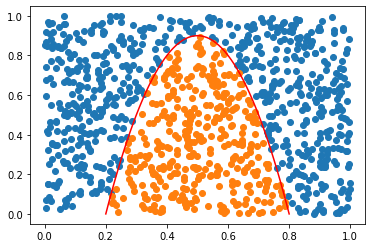

In [4]:
# Visualize dataset
plt.scatter(*pos.T)
plt.scatter(*neg.T)
xs = np.arange(x1, x2, 0.01)
plt.plot(xs, decision_bound(xs), 'r')

#### Generate random linear and nonlinear resistive networks

In [10]:
# Parameters
nodes = 100
density = 5/(nodes-1) # limit average degree to 5
denser = 0.5
diode_thresh = 0.1 # on average each node has 1 diode
mask = np.random.uniform(0, 0.5, (nodes, nodes))
mask = mask + mask.T
con = mask < density
dense = mask < denser
diodes = mask < diode_thresh

In [11]:
# Create the linear network -- initialize random (symmetric) resistor values and apply 
# the connectivity mask
tmp = np.random.rand(nodes, nodes)
lin_network = (tmp + tmp.T) * dense

In [39]:
# Create the nonlinear network -- initialize random (symmetric) resistor values and apply 
# the connectivity mask. Then, apply the diode mask by assigning random directions to each diode.
relu_network = (tmp + tmp.T) * (dense & ~(diodes | diodes.T))
diodes_dir = tmp < tmp.T
relu_network += diodes_dir * diodes

#### Train both networks

In [40]:
node_cfg = np.concatenate((np.random.permutation([1, 1, -1] + [0]*(nodes-4)), [0]))

In [48]:
# Train linear network
trained_lin = opt.train(lin_network, train['x'][:50,], train['y'][:50,None], node_cfg, epochs=10, nu=0.5)

/opt/homebrew/lib/python3.9/site-packages/jax/_src/scipy/optimize/bfgs.py:99: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  initial_H = jnp.eye(d, dtype=x0.dtype)


In [51]:
trained_lin

(OptimizeResults(x=DeviceArray([-0.7834826 , -0.7623491 , -0.7915771 , -0.61415786,
              -0.6298748 , -0.6523577 , -0.74119794, -0.7450245 ,
              -0.6806747 , -0.68986887, -0.7277091 , -0.6973034 ,
              -0.74857783, -0.69102037, -0.8258896 , -0.76093006,
              -0.697849  , -0.6384088 , -0.7398331 , -0.6986888 ,
              -0.59869623, -0.7687257 , -0.66146874, -0.75021255,
              -0.6576012 , -0.64698195, -0.6962346 , -0.72578394,
              -0.62436974, -0.6920982 , -0.86034197, -0.72719246,
              -0.7416825 , -0.843479  , -0.6774588 , -0.70789105,
              -0.6991216 , -0.72288233, -0.74131477, -0.6416076 ,
              -0.758196  , -0.69912654, -0.72740304, -0.76100165,
              -0.6569619 , -0.7089933 , -0.66940624, -0.7825092 ,
              -0.8080962 , -0.7679843 , -0.7154144 , -0.658057  ,
              -0.70221055, -0.68671757, -0.70118904, -0.81082535,
              -0.6635666 , -0.64859277, -0.70295763, -0.71

In [42]:
# Train nonlinear network
trained_relu = opt.train(relu_network, train['x'][:50,], train['y'][:50,None], node_cfg, epochs=10, nu=0.5)

#### Compare the networks

In [45]:
# Evaluate accuracy on training data
lin_outputs = opt.inference(trained_lin, train['x'], node_cfg)[:, np.argwhere(node_cfg < 0)].squeeze()
relu_outputs = opt.inference(trained_relu, train['x'], node_cfg)[:, np.argwhere(node_cfg < 0)].squeeze()

AttributeError: 'OptimizeResults' object has no attribute 'shape'

In [30]:
lin_acc = np.count_nonzero((lin_outputs >= 0.5) == train['y']) / lin_outputs.size
relu_acc = np.count_nonzero((relu_outputs >= 0.5) == train['y']) / lin_outputs.size
lin_acc, relu_acc

(0.5875, 0.5925)

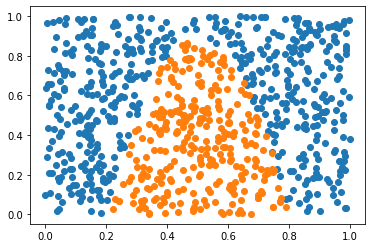

In [31]:
# Visualize the actual results
plt.scatter(*train['x'][train['y'].astype(bool)].T)
plt.scatter(*train['x'][~train['y'].astype(bool)].T)

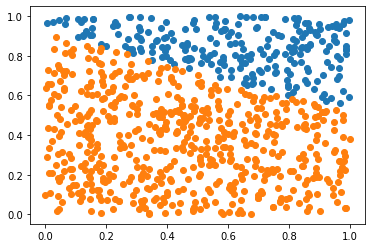

In [32]:
# Visualize linear network
plt.scatter(*train['x'][lin_outputs >= 0.5].T)
plt.scatter(*train['x'][lin_outputs < 0.5].T)

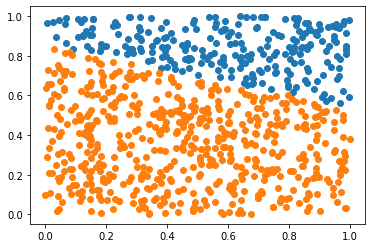

In [33]:
# Visualize relu network
plt.scatter(*train['x'][relu_outputs >= 0.5].T)
plt.scatter(*train['x'][relu_outputs < 0.5].T)

#### Compare to linear classifier

In [ ]:
cont_ftr = ['x_coord', 'y_coord']
